### Grid Searching Decision Trees

This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

In [2]:
data = pd.read_csv('data/Whickham.txt')
data['smoker'] = data['smoker'].map({'Yes': 1, 'No': 0})

X = data[['smoker', 'age']]
y = data['outcome']

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   outcome  1314 non-null   object
 1   smoker   1314 non-null   int64 
 2   age      1314 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 30.9+ KB


In [76]:
randint(low=1, high=200)

In [156]:
max_m_depth = 10
max_s_split = 40
max_s_leaf = 20

params = {
    'max_depth': [None, *np.arange(1,max_m_depth+1)],
    'min_samples_split': np.arange(2,max_s_split+1, 2),
    'criterion': ['entropy', 'gini'],
    'min_samples_leaf': [1, *np.arange(2,max_s_leaf+1, 2)]
}

dtree = DecisionTreeClassifier(random_state = 42)

searches = {
    'Grid': GridSearchCV(dtree, param_grid = params, scoring = 'accuracy', return_train_score=True),
    'Randomized': RandomizedSearchCV(dtree, param_distributions=params, scoring='accuracy', return_train_score=True, random_state=42, n_iter = 50),
    'Halving': HalvingGridSearchCV(dtree, param_grid=params, scoring = 'accuracy', return_train_score=True, random_state=42),
    'HalvingRandom': HalvingRandomSearchCV(dtree, param_distributions=params, scoring='accuracy', return_train_score=True, random_state=42),
}

data_dict = {}
for name, search_cv in searches.items():
    tmp = search_cv.fit(X, y)

    score_time = tmp.cv_results_['mean_score_time'].sum()
    fit_time = tmp.cv_results_['mean_fit_time'].sum()
    mean_time_per_param = (tmp.cv_results_['mean_score_time'].mean() + tmp.cv_results_['mean_fit_time'].mean())
    train_score = tmp.cv_results_['mean_train_score'][tmp.best_index_]

    data_dict[name] = {
        'train_acc': tmp.best_score_,
        'test_acc': train_score,
        **tmp.best_params_,
        'mean_time_per_param': mean_time_per_param * tmp.n_splits_,
        'total_score_time': score_time,
        'total_fit_time': fit_time,
        'total_time': (score_time + fit_time) * tmp.n_splits_,
    }

results = pd.DataFrame.from_records(data_dict).T

In [157]:
results

,train_acc,test_acc,criterion,max_depth,min_samples_leaf,min_samples_split,mean_time_per_param,total_score_time,total_fit_time,total_time
Grid,0.853122,0.859589,gini,None,18,2,0.017318,6.231904,10.531523,83.817134
Halving,0.855296,0.863645,entropy,3,10,32,0.012558,7.663811,10.34944,90.066252
HalvingRandom,0.844185,0.859933,gini,1,10,20,0.012272,0.103101,0.137426,1.202633
Randomized,0.853122,0.859399,gini,9,20,34,0.017438,0.065043,0.109336,0.871895


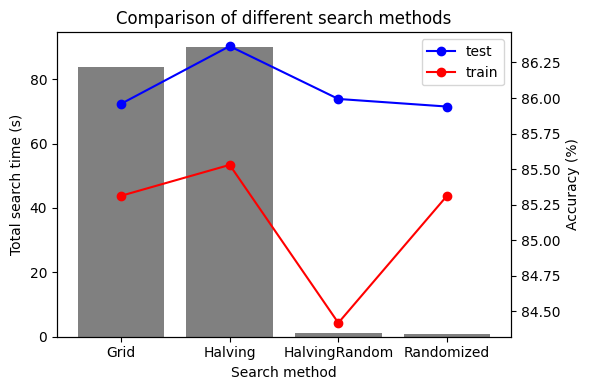

In [163]:
f, ax1 = plt.subplots(figsize=(6,4))

ax2 = ax1.twinx()

ax1.bar(results.index, results.total_time, color = 'gray')
ax2.plot(results.index, 100*results.test_acc, c = 'b', label = 'test', marker='o')
ax2.plot(results.index, 100*results.train_acc, c='r', label = 'train', marker='o')

ax1.set_ylabel('Total search time (s)')
ax2.set_ylabel('Accuracy (%)')

ax1.set_title('Comparison of different search methods')
ax1.set_xlabel('Search method')

plt.legend()

plt.tight_layout()
plt.savefig('try_14.2-plot.png')
plt.show()

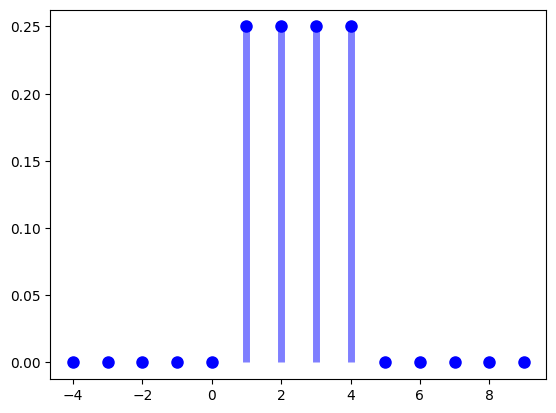

In [79]:
low  = 1
high = 5

fig, ax = plt.subplots(1, 1)
x = np.arange(low - 5, high + 5)
ax.plot(x, randint.pmf(x, low, high), 'bo', ms=8, label='randint pmf')
ax.vlines(x, 0, randint.pmf(x, low, high), colors='b', lw=5, alpha=0.5)